# Take an image, filter intermediate colors, then shrink
Actually better to filter before shrinking, for higher fidelity (for future) These images were processed in box, and then moved to github

In [1]:
import cvfunc
import cv2
import scale
import symmetry
from tqdm import tqdm
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
#import json
#from multiprocess import Pool
#from time import time
#from functools import partial
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
# This is the code from Hernan Freedman: 

import cv2
import numpy as np
from numpy import loadtxt
from PIL import Image
import os

def show_image(window_name, image):
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.imshow(window_name, image)
    cv2.waitKey(1)
    return

def how_gray(bgr_pixel, gray_pixel):
    t = [abs(int(gray_pixel) - int(bgr_pixel[0])),abs(int(gray_pixel) - int(bgr_pixel[1])),abs(
        int(gray_pixel) - int(bgr_pixel[2]))]
    return max(t)

def dif_bgr(bgr_pixel1, bgr_pixel2):
    t = abs(int(bgr_pixel1[0]) - int(bgr_pixel2[0])) + abs(int(bgr_pixel1[1]) - int(bgr_pixel2[1])) + abs(
        int(bgr_pixel1[2]) - int(bgr_pixel2[2]))
    return t

def in_array(element, array):
    is_present = False
    for e in array:
        if (e == element).all():
            is_present = True
    return is_present

def middle_color_repair(image, col_palette):

    h, w = image.shape[:2]
    mask = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret_image = image.copy()
    pixels_to_fix = 0
    for y in range(h):
        for x in range(w):
            found = False
            for c in range(len(col_palette)):
                if (np.array([image[y][x][2], image[y][x][1],image[y][x][0]]) == col_palette[c]).all():
                    found = True
            if not found:
                mask[y][x] = 0
                pixels_to_fix += 1
            else:
                mask[y][x] = 255
    print("Image:", w, "x", h, " - total pixels:", w*h)
    print("Pixels to fix:", pixels_to_fix)
    min_h = 256
    min_x = -1
    min_y = -1
    for y in range(h):
        for x in range(w):
            if mask[y][x] == 0:
                min_d = 256
                min_x = -1
                min_y = -1
                h_gray = how_gray(image[y][x], gray[y][x])
                for xx in range(x-1, x+2):
                    for yy in range(y-1, y+2):
                        #if x == 36 and y == 83:
                        #    print(xx,yy,dif_bgr(image[y][x], image[yy][xx]), image[y][x], image[yy][xx])
                        if xx >= 0 and yy >= 0 and xx < w and yy < h and not(xx == x and yy == y) and mask[yy][xx] == 255:

                            if dif_bgr(image[y][x], image[yy][xx]) < 30:
                                min_d = -1
                                min_x = xx
                                min_y = yy
                            else:
                                h_gray_this = how_gray(image[yy][xx], gray[yy][xx])
                                if h_gray < 30 and h_gray_this < 30:
                                    dif_gray = abs(int(gray[y][x]) - int(gray[yy][xx]))
                                    if dif_gray < min_d:
                                        min_d = dif_gray
                                        min_x = xx
                                        min_y = yy
                                else:
                                    dif_h1 = abs(int(hsv[y][x][0])-int(hsv[yy][xx][0]))
                                    dif_h2 = abs(180 - dif_h1)
                                    dif_h = min([dif_h1, dif_h2])
                                    if dif_h < min_d:
                                        min_d = dif_h
                                        min_x = xx
                                        min_y = yy
                ret_image[y][x] = image[min_y][min_x]

    return ret_image, mask


def process_file(path, file):

    print("Process file:", path+file)
    pil_image = Image.open(path+file)
    col = pil_image.getcolors(maxcolors=256*256)
    colors = []
    for c in col:
        if c[0] > 20: #Look for more than 20 repetitions of the same color
            if in_array(c[1], palette):
                print(c[1], "present", c[0], "times")
            else:
                print(c[1], "present", c[0], "times but it not in palette.txt!!! - You can update palette.txt")
            colors.append(c[1])

    image = cv2.imread(path+file)
    new_image, new_mask = middle_color_repair(image, palette) #Run with colors in palette.txt
    #new_image, new_mask = middle_color_repair(image, colors) #Run with colors detected in image

    #show_image('source image', image)
    #show_image('repaired image', new_image)
    print("Save output:", path+'out/'+file)
    cv2.imwrite(path+'out/'+file, new_image)
    #cv2.waitKey()
    print("-------------------------------------------------------------")


# Take the georeferenced originals for Roberto, trim off the pink, shrink: 

In [ ]:
#Paths
# # for Auburn 2021 images, and if you just want "E" images, filter on first line with: "/*E.png"
# original_images_path = '/Users/michaelsmith/Library/CloudStorage/Box-Box/2D_symmetry_2021/Annotated/Auburn_2021'
original_images_path = '/Users/michaelsmith/Library/CloudStorage/Box-Box/2D_symmetry_2021/Annotated/georeferenced_for_roberto_molinari/originals'
scaled_images_path = "/Users/michaelsmith/Library/CloudStorage/Box-Box/2D_symmetry_2021/Annotated/georeferenced_for_roberto_molinari/shrink"


In [ ]:
# this will shrink the images

for file in tqdm(glob.glob(original_images_path+"/EXAMPLE_IMAGE.png"),desc="Progress"):
    print(file)
    original = cv2.imread(file)
    # IF it has the pink border, use this to crop:
    border_cut = 20
    original = original[border_cut:original.shape[0]-border_cut, border_cut:original.shape[1]-border_cut]
    resized = scale.resize(original,100) # height, in PX 
#     # if you need to FLIP the image: 
#     resized = np.fliplr(resized)
    # and save the image: 
    savestring = os.path.join(scaled_images_path,f"{os.path.splitext(os.path.basename(file))[0]}.png")
    cv2.imwrite(savestring,resized)


# Ok, and now we filter out the oddity colors using Hernan's code: 

In [ ]:

# input_path = 'C:/2022/Michael Smith/'
input_path = '/Users/michaelsmith/Library/CloudStorage/Box-Box/2D_symmetry_2021/Annotated/georeferenced_for_roberto_molinari/shrink/'

palette = loadtxt('palette.txt', delimiter=',')

png_files = [x for x in os.listdir(input_path) if (x.endswith("East_day169_18Jun2013_S_copy_edited2.png") )] # MLS MODIFIED .PNG TO REDUCE NUMBER OF TEST IMAGES...

for file_name in png_files:
    process_file(input_path, file_name)
    

In [ ]:

# Little fixes that I had to make using gimp! 
# North, day 134, east, had a small speck leftover from the pink rectangle
# East, 18 June, South, looks like the gray color was incorrect... gray on left of nest was kosher... 




In [ ]:
# # this will shrink the images

# for file in tqdm(glob.glob(original_images_path+"/East*.png"),desc="Progress"):
#     original = cv2.imread(file)
#     (h, w) = original.shape[:2]
#     height = 100
#     r = height / float(h)
#     dim = (int(w * r), height)
#     resized = cv2.resize(original, dim, interpolation=cv2.INTER_NEAREST)
#     savestring = os.path.join(scaled_images_path,f"{os.path.splitext(os.path.basename(file))[0]}.png")
#     cv2.imwrite(savestring,resized)


In [ ]:
# Load a shrink image:

In [4]:

# test = cv2.imread('/Users/michaelsmith/Library/CloudStorage/Box-Box/2D_symmetry_2021/Annotated/georeferenced_for_roberto_molinari/shrink/col76/col76_day50_24may2021_E.png')
test = cv2.imread('/Users/michaelsmith/Documents/GitHub/symmetry_optimizer/images/East/East_day105_16Apr2013_N.png')


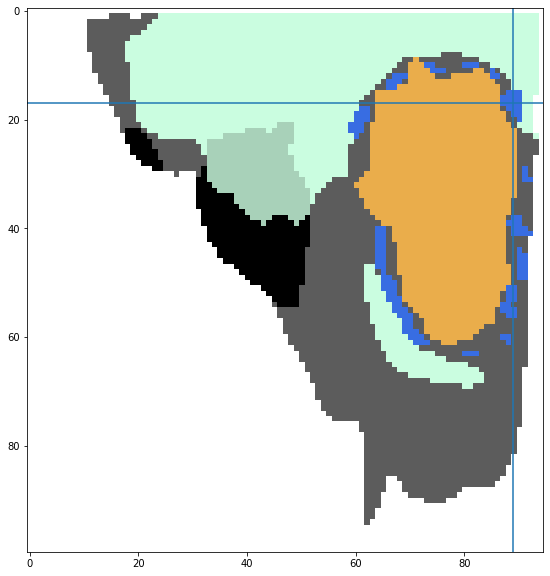

In [5]:
plt.imshow(test)
plt.axvline(89)
plt.axhline(17)

In [6]:
# So... how many colors are in here: 116 colors. So... that's the problem! 
len(cvfunc.get_colors(test)[0])

7

In [8]:
np.unique(test)

array([  0,  56,  75,  92, 109, 168, 173, 185, 202, 209, 224, 226, 234,
       253, 255], dtype=uint8)

In [9]:
# this finds unique PIXEL values, cause it takes the combination (RGB) values: 
np.unique(test.reshape(-1, test.shape[2]), axis=0)

array([[  0,   0,   0],
       [ 56, 109, 226],
       [ 92,  92,  92],
       [168, 209, 185],
       [202, 253, 224],
       [234, 173,  75],
       [255, 255, 255]], dtype=uint8)

In [10]:
test.reshape(-1, test.shape[2])

array([[255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       ...,
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255]], dtype=uint8)

In [12]:
test.shape

(100, 95, 3)

In [ ]:
# # this is Y,X: 
# test[17][89]

In [ ]:

# for file in glob.glob(scaled_images_path+"/col*/*.png"):
#     print(file)
#     test = cv2.imread(file)
#     print(len(cvfunc.get_colors(test)[0]))
#     print('---')


# Need to make sure all images are on the SAME x-y size (e.g. 100 x 100 px)
Did a couple different things, for resizing based on current size, OR adding white space for early dates

In [28]:

test = cv2.imread('/Users/michaelsmith/Desktop/col62_day241_01December2021_W_cropped.png')


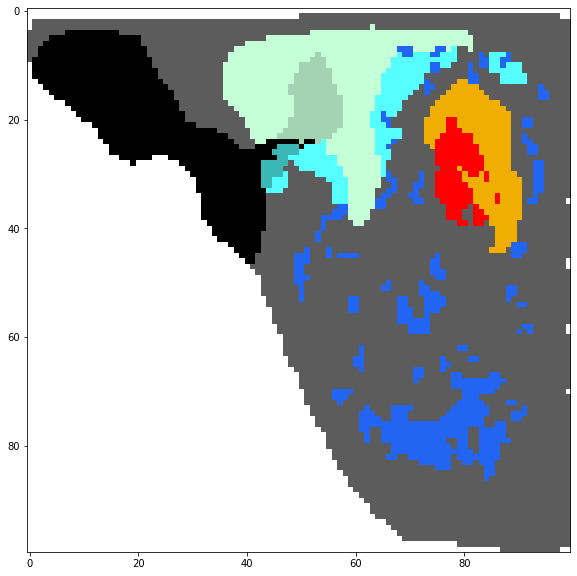

In [29]:
plt.imshow(test)
plt.show()

In [35]:
test.shape

(100, 69, 3)

In [31]:
len(np.unique(test.reshape(-1, test.shape[2]), axis=0))

10

In [72]:
# To see which files are oversize: 
path = '/Users/michaelsmith/Desktop/East'

for file in glob.glob(path+"/*.png"):
    test = cv2.imread(file)
    
    if test.shape[0] > 100:
        print(file)
        print(test.shape)
        print(file)
    elif test.shape[1] > 100:
        print (file)
        print(test.shape)
        print(file)
    else:
        continue
    print('---')

In [56]:
# Rewrote the function for "resize width" cause there were some that had height correct, but not width. 

def resize(img,scale_height):
    h,w,c = img.shape
    resized = cv2.resize(img,(int(w*scale_height/h),scale_height),fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
    return resized

def resize_width(img,scale_width):
    h,w,c = img.shape
    resized = cv2.resize(img,(int(w*scale_width/w),scale_width),fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
    return resized


In [65]:
# plt.imshow(resized)

In [167]:
# THIS WILL MAKE IMAGE 100x100 PX, but if the nest is smaller in one dimension, it'll stretch it! Beware! 

# Dragged a folder of all images onto desktop (to keep from messing up the ones on github)
# resize each image to be 100 x 100
# save in same folder, then check, then re-upload

path = '/Users/michaelsmith/Desktop/Col61'

for file in glob.glob(path+"/col61_day71_14June2021*.png"): # can adjust here to get specific images
    test = cv2.imread(file)
    resized = resize_width(test,100)
    print(file)
    print(test.shape)
    print(resized.shape)
    print('---')
    
    # Save the image: 
    savestring = os.path.join(path,f"{os.path.splitext(os.path.basename(file))[0]}.png")
    cv2.imwrite(savestring,resized)


/Users/michaelsmith/Desktop/Col61/col61_day71_14June2021_E.png
(95, 95, 3)
(100, 100, 3)
---
/Users/michaelsmith/Desktop/Col61/col61_day71_14June2021_W.png
(80, 79, 3)
(100, 100, 3)
---


In [87]:
path = '/Users/michaelsmith/Desktop/Col61'
for file in glob.glob(path+"/*.png"):
    test = cv2.imread(file)
    print(test.shape)
    print(len(np.unique(test.reshape(-1, test.shape[2]), axis=0)))

(100, 100, 3)
9
(100, 100, 3)
10
(100, 100, 3)
10
(96, 96, 3)
7
(100, 100, 3)
8
(100, 100, 3)
10
(100, 61, 3)
7
(100, 89, 3)
10
(100, 100, 3)
10
(100, 100, 3)
3
(100, 61, 3)
7
(100, 89, 3)
10
(100, 100, 3)
12
(100, 100, 3)
3
(100, 100, 3)
10
(100, 100, 3)
10
(100, 100, 3)
10
(82, 81, 3)
7
(100, 100, 3)
8
(100, 100, 3)
10
(100, 99, 3)
5
(100, 100, 3)
9
(100, 100, 3)
10
(100, 99, 3)
8
(97, 97, 3)
7
(100, 100, 3)
6
(100, 100, 3)
10
(96, 97, 3)
7
(100, 100, 3)
8
(100, 100, 3)
6
(100, 100, 3)
5
(100, 100, 3)
9
(100, 100, 3)
7
(100, 100, 3)
10
(100, 100, 3)
7
(100, 100, 3)
10
(100, 100, 3)
7
(100, 100, 3)
10
(100, 100, 3)
8
(96, 96, 3)
9
(100, 100, 3)
7
(100, 100, 3)
6
(100, 69, 3)
8
(100, 100, 3)
10
(100, 100, 3)
8
(100, 100, 3)
10
(100, 100, 3)
8
(100, 100, 3)
7
(100, 100, 3)
5
(100, 69, 3)
8


In [165]:
# Method to add WHITE to left side of the figure (for early dates, when Col61 hadn't filled the space):

path = '/Users/michaelsmith/Desktop/Col61'

# test = cv2.imread('/Users/michaelsmith/Desktop/Col61/col61_day10_14apr2021_E.png')

# First, fix the widths: 
for file in glob.glob(path+"/*.png"):
    print(file)
    test = cv2.imread(file)
    # print(savestring)
    print(test.shape)
    # print(len(np.unique(test.reshape(-1, test.shape[2]), axis=0)))
    if test.shape[1]<100:
        print('to fix width')
        width_of_image = test.shape[1]
        height_of_image = test.shape[0]
        width_to_add = 100 - width_of_image
        blank_image = np.zeros([height_of_image,width_to_add,3],dtype=np.uint8) # THIS IS THE BLANK SPACE
        blank_image.fill(255)
        combined_image = cv2.hconcat([blank_image, test]) # put the blank image to the LEFT of image
        # save the image:
        savestring = os.path.join(path,f"{os.path.splitext(os.path.basename(file))[0]}.png")
        cv2.imwrite(savestring,combined_image)
    else:
        continue


# AND THEN, THE HEIGHTS... 
# First, fix the widths: 
for file in glob.glob(path+"/*.png"):
    print(file)
    test = cv2.imread(file)
    print(test.shape)
    # print(len(np.unique(test.reshape(-1, test.shape[2]), axis=0)))
    if test.shape[0]<100:
        print('to fix height')
        width_of_image = test.shape[1]
        height_of_image = test.shape[0]
        height_to_add = 100 - height_of_image
        blank_image = np.zeros([height_to_add,width_of_image,3],dtype=np.uint8)
        blank_image.fill(255)
        combined_image = cv2.vconcat([test, blank_image]) # put the blank image to the LEFT of image
        # plt.imshow(combined_image)
        # plt.show()
        # save the image:
        savestring = os.path.join(path,f"{os.path.splitext(os.path.basename(file))[0]}.png")
        cv2.imwrite(savestring,combined_image)
    else:
        continue


/Users/michaelsmith/Desktop/Col61/col62_day170_21September2021_W.png
(100, 100, 3)
/Users/michaelsmith/Desktop/Col61/col62_day190_11October2021_W.png
(100, 100, 3)
/Users/michaelsmith/Desktop/Col61/col62_day200_21October2021_E.png
(100, 100, 3)
/Users/michaelsmith/Desktop/Col61/col61_day71_14June2021_E.png
(100, 100, 3)
/Users/michaelsmith/Desktop/Col61/col62_day159_10September2021_E.png
(100, 100, 3)
/Users/michaelsmith/Desktop/Col61/col62_day221_11November2021_W.png
(100, 100, 3)
/Users/michaelsmith/Desktop/Col61/col61_day10_14apr2021_W.png
(100, 100, 3)
/Users/michaelsmith/Desktop/Col61/col61_day32_6may2021_W.png
(100, 100, 3)
/Users/michaelsmith/Desktop/Col61/col61_day40_14may2021_E.png
(100, 100, 3)
/Users/michaelsmith/Desktop/Col61/col61_day110_23July2021_E.png
(100, 100, 3)
/Users/michaelsmith/Desktop/Col61/col61_day10_14apr2021_E.png
(100, 100, 3)
/Users/michaelsmith/Desktop/Col61/col61_day32_6may2021_E.png
(100, 100, 3)
/Users/michaelsmith/Desktop/Col61/col61_day40_14may2021_W